In [1]:
import wandb
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from train_utils import update_dir_name, get_default_configs
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [2]:
training_config, model_config, cluster_config = get_default_configs(random_string="X", wandb_project="btbank_tests")


In [4]:
random_strings = ["CONT_EXP_CLS1", "CONT_EXP_CLS2", "CONT_EXP_CLS3"]


learning_rates = sorted([0.0015, 0.0021, 0.003, 0.0042, 0.006, 0.0084])
future_bin_idx = [1]
use_cls_token_options = [0, 1]
spec_values = [1]#, 0]

condition_str = [f"{cls_token}_{lr}" for cls_token in use_cls_token_options for lr in learning_rates]

# Initialize histories dict
histories = {cs: [] for cs in condition_str}

# Generate all run IDs and collect histories
for cs in condition_str:
    for rs in random_strings:
        training_config['random_string'] = rs
        training_config['learning_rate'] = float(cs.split("_")[1])
        training_config['future_bin_idx'] = future_bin_idx[0]
        model_config['transformer']['use_cls_token'] = int(cs.split("_")[0])
        model_config['electrode_embedding']['spectrogram'] = spec_values[0]

        run_id = update_dir_name(model_config, training_config, cluster_config)
        
        runs = api.runs(f"andrii-mit/{cluster_config['wandb_project']}", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if '_step' not in history.columns:
                print(f"Run {run_id} has no '_step' column")
                continue
            n_epochs = 100
            if history['_step'].max() >= n_epochs:  # Only include if trained for full 100 epochs
                histories[cs].append(history)
            else:
                print(f"Run {run_id} did not train for full {n_epochs} epochs ({history['_step'].max()} epochs)")

for cs in condition_str:
    print(f"condition {cs}: {len(histories[cs])} runs")

condition 0_0.0015: 3 runs
condition 0_0.0021: 3 runs
condition 0_0.003: 3 runs
condition 0_0.0042: 3 runs
condition 0_0.006: 3 runs
condition 0_0.0084: 3 runs
condition 1_0.0015: 3 runs
condition 1_0.0021: 3 runs
condition 1_0.003: 3 runs
condition 1_0.0042: 3 runs
condition 1_0.006: 3 runs
condition 1_0.0084: 3 runs


In [5]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume', 'eval_auroc/average_gpt2_surprisal', 'eval_auroc/average_word_part_speech']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC', 'Decoding GPT2 Surprisal AUROC', 'Decoding Word Part Speech AUROC']
n_last_measurements = 3

# Initialize results dictionary
results = {cs: {metric: [] for metric in metrics} 
          for cs in condition_str}

# Calculate means for each run
for cs in condition_str:
    for history in histories[cs]:
        for metric in metrics:
            h = np.array(list(history[metric].iloc))
            h = h[~np.isnan(h)]
            results[cs][metric].append(h[-n_last_measurements:].mean())

# Print results
for cs in condition_str:
    print(f"\ncs {cs}:")
    for metric in metrics:
        values = results[cs][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



cs 0_0.0015:
train_loss: 0.3669 (across 3 runs)
test_loss: 0.5859 (across 3 runs)
eval_auroc/average_speech: 0.8430 (across 3 runs)
eval_auroc/average_volume: 0.7398 (across 3 runs)
eval_auroc/average_gpt2_surprisal: 0.5198 (across 3 runs)
eval_auroc/average_word_part_speech: 0.5100 (across 3 runs)

cs 0_0.0021:
train_loss: 0.1847 (across 3 runs)
test_loss: 0.4366 (across 3 runs)
eval_auroc/average_speech: 0.8579 (across 3 runs)
eval_auroc/average_volume: 0.7333 (across 3 runs)
eval_auroc/average_gpt2_surprisal: 0.5276 (across 3 runs)
eval_auroc/average_word_part_speech: 0.5092 (across 3 runs)

cs 0_0.003:
train_loss: 0.1247 (across 3 runs)
test_loss: 0.4362 (across 3 runs)
eval_auroc/average_speech: 0.8711 (across 3 runs)
eval_auroc/average_volume: 0.7461 (across 3 runs)
eval_auroc/average_gpt2_surprisal: 0.5281 (across 3 runs)
eval_auroc/average_word_part_speech: 0.5094 (across 3 runs)

cs 0_0.0042:
train_loss: 0.1162 (across 3 runs)
test_loss: 0.3507 (across 3 runs)
eval_auroc/aver

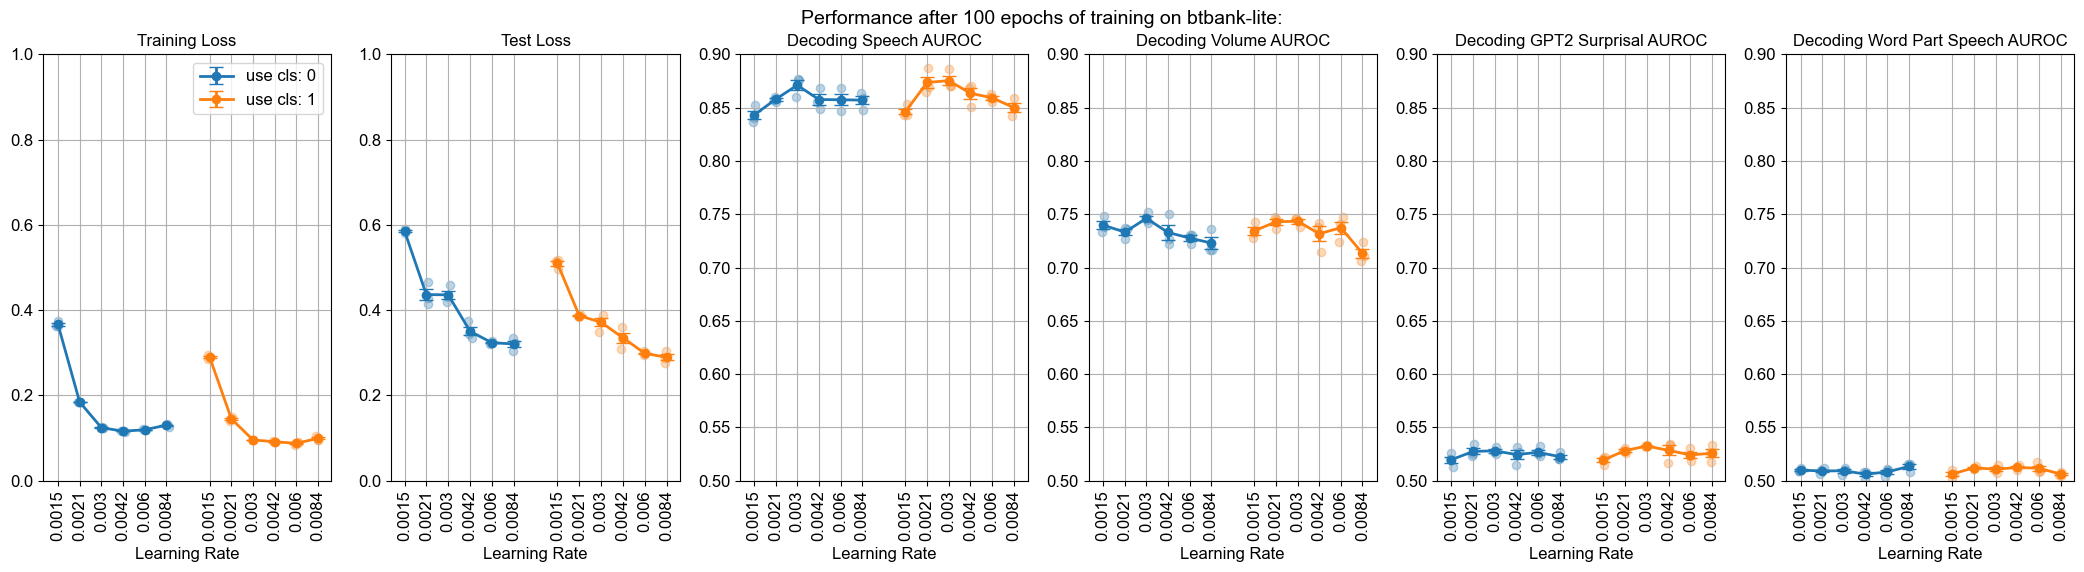

In [8]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(3.5*len(metrics), 6))

for i, metric in enumerate(metrics):
    for cls_token_idx, cls_token in enumerate(use_cls_token_options):
        means = []
        errors = []
        ps = []
        all_values = []
        all_ps = []
        
        # Calculate base x position for this batch size group
        base_x = cls_token_idx * (len(learning_rates) + 1)  # +1 for spacing between groups
        
        # Get data for each learning rate within this batch size
        for lr_idx, lr in enumerate(learning_rates):
            cs = f"{cls_token}_{lr}"  # Reconstruct condition string
            values = results[cs][metric] if cs in results else []
            
            if values:
                means.append(np.mean(values))
                if error_type == 'std':
                    errors.append(np.std(values))
                else:  # sem
                    errors.append(np.std(values) / np.sqrt(len(values)))
                
                x_ind = base_x + lr_idx
                ps.append(x_ind)
                
                # Store individual points
                all_values.extend(values)
                all_ps.extend([x_ind] * len(values))
        
        # Plot individual points with some jitter and transparency
        jitter = 0.1
        axes[i].scatter(
            [p + np.random.uniform(-jitter, jitter) for p in all_ps],
            all_values,
            alpha=0.3,
            color=f'C{cls_token_idx}',
            zorder=1
        )
        
        # Plot mean and error bars for this batch size group
        if means:  # Only plot if we have data
            error_label = f'use cls: {cls_token}'
            axes[i].errorbar(ps, means, yerr=errors, marker='o', capsize=5, 
                        color=f'C{cls_token_idx}', zorder=2, label=error_label,
                        linewidth=2)
    
    # Set x-ticks and labels for learning rates
    all_x_ticks = []
    all_x_labels = []
    for cls_token_idx, cls_token in enumerate(use_cls_token_options):
        base_x = cls_token_idx * (len(learning_rates) + 1)
        all_x_ticks.extend([base_x + i for i in range(len(learning_rates))])
        all_x_labels.extend([f"{lr}" for lr in learning_rates])
    
    axes[i].set_xticks(all_x_ticks, all_x_labels, rotation=90)
    axes[i].set_xlabel('Learning Rate')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    if i==0: axes[i].legend()

axes_lime = [(0, 1), (0, 1), (0.5, .9), (0.5, .9), (0.5, .9), (0.5, .9)]
for i, ax in enumerate(axes):
    ax.set_ylim(axes_lime[i])

plt.suptitle(f'Performance after {n_epochs} epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig(f'analyses/exp_cls_{random_strings[0].lower()}_spec{spec_values[0]}.pdf', bbox_inches='tight', dpi=300)
plt.show()
